In [1]:
%cd ~/work/deeplearning/

/home/asaeed9/work/deeplearning


## Headers

In [2]:
from theano.sandbox import cuda
cuda.use('gpu1')
%matplotlib inline
from __future__ import print_function, division
#path="../data/2cat/sample"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
from keras.preprocessing import image, sequence
import os, sys, cv2
from shutil import copyfile

####
from keras.layers.convolutional import *
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 1 failed:
Bad device number 1. Only 1 devices available.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5105)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to

In [3]:
data_dir="/home/asaeed9/work/data/2cat"
path="/home/asaeed9/work/data/2cat/sample/"
results_path = "/home/asaeed9/work/data/2cat/sample/results"
test_path = path + '/test/' #We use all the test data
%cd ../data/2cat/train

/home/asaeed9/work/data/2cat/train


## Data Preparation

In [4]:
#grey images - minimal image augmentation

#clean previous data
def adjust_prev_data():
    %mv $data_dir/valid/* $data_dir/train/
    
    %rm $path/train/cats/*
    %rm $path/train/dogs/*
    %rm $path/valid/cats/*
    %rm $path/valid/dogs/*

#copy training images
def copy_samples(train, validation):
    
    #clean previous data
    adjust_prev_data()
    
    #build validation set
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): os.rename(shuf[i], '../valid/' + shuf[i]) 
    
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(train): copyfile(shuf[i], '../sample/train/' + shuf[i]) 
    %mv ../sample/train/cat*.jpg ../sample/train/cats/
    %mv ../sample/train/dog*.jpg ../sample/train/dogs/
    
    %cd ../valid

    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): copyfile(shuf[i], '../sample/valid/' + shuf[i]) 
    %mv ../sample/valid/cat*.jpg ../sample/valid/cats/
    %mv ../sample/valid/dog*.jpg ../sample/valid/dogs/
    %cd $data_dir/train

def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

def pred_batch(imgs, classes):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[:5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))


def generate_size_graph(fig_no, training_size, accuracy, loss, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy/Loss')
    plt.title('Training Size vs Accuracy/Loss')
    plt.grid(True)
    plt.legend(['Accuracy','Loss'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg') 
    
def get_train_model(tr_batches, val_batches, epoch):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 256,256)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
#             Convolution2D(64,3,3, activation='relu'),
#             BatchNormalization(axis=1),
            #MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Flatten(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model 

def get_test_model():
    model = Sequential([
                BatchNormalization(axis=1, input_shape=(3,256,256)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
    #             Convolution2D(64,3,3, activation='relu'),
    #             BatchNormalization(axis=1),
                #MaxPooling2D((3,3)),
                Convolution2D(64,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Flatten(),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dense(2, activation='softmax')
            ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])  
    
    return model

### Training

In [5]:
%cd $data_dir/train

nepoch = 50
batch_size = 16
training_range = range(3000, 15001, 3000)
#%rm $path/results/*

gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

#for train in training_range:
model = None
train = 15000
valid = int(math.floor(.2 * train))
print('sample size: {}'.format(train))
copy_samples(train, valid)

tr_batches = gen_t.flow_from_directory(path + 'train', batch_size=batch_size)
val_batches = gen_t.flow_from_directory(path + 'valid', class_mode='categorical', shuffle=True, batch_size=batch_size * 2)

model = get_train_model(tr_batches, val_batches, nepoch)
model.save_weights(results_path+ '/' + 'ft_' + str(train) + '.e' + str(nepoch))

/home/asaeed9/work/data/2cat/train
sample size: 15000
/home/asaeed9/work/data/2cat/valid
/home/asaeed9/work/data/2cat/train
Found 15000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Epoch 1/2
15000/15000 [==============================] - 246s - loss: 0.8235 - acc: 0.6261 - val_loss: 0.9528 - val_acc: 0.6177
Epoch 2/2
15000/15000 [==============================] - 239s - loss: 0.6727 - acc: 0.6744 - val_loss: 1.3001 - val_acc: 0.6390
Epoch 1/48
15000/15000 [==============================] - 247s - loss: 0.6017 - acc: 0.7038 - val_loss: 1.3041 - val_acc: 0.6457
Epoch 2/48
15000/15000 [==============================] - 242s - loss: 0.5688 - acc: 0.7198 - val_loss: 1.1035 - val_acc: 0.6450
Epoch 3/48
15000/15000 [==============================] - 241s - loss: 0.5346 - acc: 0.7372 - val_loss: 1.1567 - val_acc: 0.6697
Epoch 4/48
15000/15000 [==============================] - 241s - loss: 0.5206 - acc: 0.7477 - val_loss: 1.1976 - val_acc: 0.6863
Epoch 5/48
15000/15

## Prediction

In [6]:
training_range = range(3000, 18001, 3000)


File being processed: ft_15000.e50
Found 3000 images belonging to 2 classes.
2976/3000 [============================>.] - ETA: 0s
Loss:0.233011357625, Accuracy:0.920333333492

File being processed: ft_12000.e50
Found 3000 images belonging to 2 classes.
2976/3000 [============================>.] - ETA: 0s
Loss:0.338880252699, Accuracy:0.879666666508

File being processed: ft_18000.e50
Found 3000 images belonging to 2 classes.
2976/3000 [============================>.] - ETA: 0s
Loss:0.202349482854, Accuracy:0.924

File being processed: ft_3000.e50
Found 3000 images belonging to 2 classes.
2976/3000 [============================>.] - ETA: 0s
Loss:0.768557558576, Accuracy:0.747333333492

File being processed: ft_6000.e50
Found 3000 images belonging to 2 classes.
2976/3000 [============================>.] - ETA: 0s
Loss:0.580998920759, Accuracy:0.825333333492

File being processed: ft_9000.e50
Found 3000 images belonging to 2 classes.
3000/3000 [==============================] - 4s     



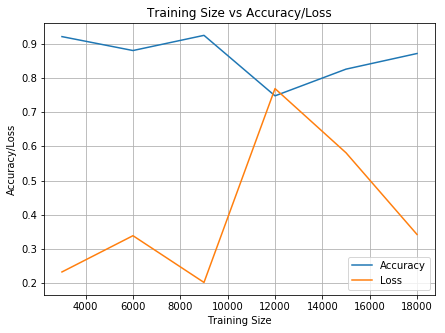

In [7]:
model = None
model = get_test_model()
loss_score = []
accuracy_score = []
training_size = training_range

os.chdir(results_path)
files = filter(os.path.isfile, os.listdir(results_path))
files.sort(key=lambda x: os.path.getmtime(x))

for f in files:
    
    print("\nFile being processed: {}".format(f))
    
    train_size = int(f[f.find('_')+1 : f.find('.')])
    epoch = int(f[f.find('e')+1 : ])

    model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(epoch))
    
    gen_test = image.ImageDataGenerator()
    test_batches = gen_test.flow_from_directory(path+'test', class_mode=None, target_size=(256,256), shuffle=False, batch_size=1)
    test_data = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
    test_labels = onehot(test_batches.classes)
    score = model.evaluate(test_data, test_labels)
    
    loss_score.append(score[0])
    accuracy_score.append(score[1])
    
    print("\nLoss:{}, Accuracy:{}".format(score[0], score[1]))

#print(loss_score, accuracy_score)
#fig_no, training_size, accuracy, loss, start_size, end_size
generate_size_graph(1, training_size, accuracy_score, loss_score, min(training_size), max(training_size))

In [9]:
accuracy_score = [0.747333333492, 0.825333333492, 0.871, 0.879666666508, 0.920333333492, 0.924]
loss_score = [0.768557558576, 0.580998920759, 0.342369473696, ]

[0.92033333349227908,
 0.87966666650772096,
 0.92400000000000004,
 0.74733333349227904,
 0.825333333492279,
 0.871]

In [ ]:
generate_size_graph(1, training_size, accuracy_score, loss_score, min(training_size), max(training_size))

In [ ]:
def get_numpy_images(data_path):
    data_dir_list = os.listdir(data_path)
    img_data_list=[]
    labels=[]

    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:

            if 'cat' in img:
                labels.append(0)
            else:
                labels.append(1)

            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            print(type(input_img), input_img.shape)
            input_img_resize=cv2.resize(input_img,(256,256))
            print(type(input_img_resize), input_img_resize.shape)
            exit(1)
            img_data_list.append(input_img_resize)

    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    return img_data, labels

In [ ]:
test_img_data, test_labels = get_numpy_images(test_path)
#test_img_data = np.expand_dims(test_img_data, axis=1)
test_nsamples = test_img_data.shape[0]
test_input_shape=test_img_data[0].shape

test_Y = np_utils.to_categorical(test_labels, 2)

In [ ]:
score = model.evaluate(test_img_data, test_Y, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model.predict_classes()

In [ ]:
filenames = test_batches.filenames
np.set_printoptions(suppress=True, precision=4)
print(filenames[:10])
print(preds[:10])
#our_labels = np.round(preds[:, 0])
#our_labels[:10]
#our_preds = preds[:, 1]

In [ ]:
#print(preds[:10])
filenames = test_batches.filenames
np.set_printoptions(suppress=True, precision=4)
filenames[:10]

In [ ]:
expected_labels = get_test_labels(test_batches.filenames)